# Getting close to the convolutions

### 1. Reading and opening images

The following code enables to read an image, put it in a numpy array and display it in the notebook.

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

sample image shape:  (600, 600, 3)


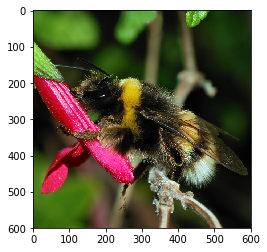

In [2]:
sample_image = imread(os.path.join("figures", "bumblebee.png"))
sample_image = sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

### 2. A simple convolution filter

The goal of this section is to use Keras to perform individual convolutions on images. This section does not involve training any model yet.

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D

Using TensorFlow backend.


In [4]:
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3))
])
conv.output_shape

(None, None, None, 3)

Remember: in Keras, `None` is used as a marker for tensor dimensions with dynamic size. In this case `batch_size`, `width`, and `height` are all dynamic: they can depend on the input. Only the number of input channels (3 colors) has been fixed.

In [5]:
sample_image.shape

(600, 600, 3)

In [6]:
img_in = np.expand_dims(sample_image, 0)
img_in.shape

(1, 600, 600, 3)

#### Questions


If we apply this convolution to this image, what will be the shape of the generated feature map?

Hints:

- in Keras `padding="same"` means that convolutions uses as much padding as necessary so has to preserve the spatial dimension of the input maps or image;

- in Keras, convolutions have no strides by default.

Bonus: how much padding should be used to preserve the spatial dimensions in this particular case?

In [7]:
img_out = conv.predict(img_in)
img_out.shape

(1, 600, 600, 3)

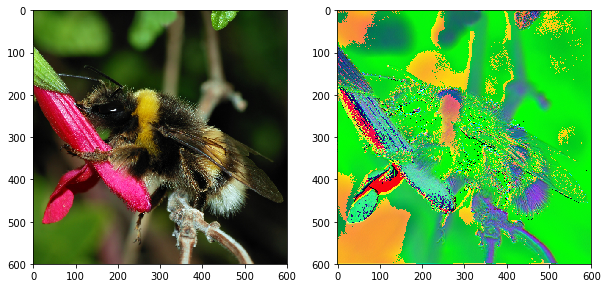

In [8]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

The output has 3 channels, hence can also be interpreted as an RGB image with matplotlib. However it is the result of a random convolutional filter applied to the original one.


Let's look at the parameters:

In [9]:
conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 3)     228       
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


#### Questions

* can you compute the number of trainable parameters from the layer hyperparameters? Hints:

    - the input image has 3 colors and a single **convolution kernel** mixes information from all the three input channels to compute its output;

    - a **convolutional layer** outputs many channels at once: each channel is the output of a distinct convolution operation (aka unit) of the layer;

    - do not forget the biases!

Solution: let's introspect the keras model:

In [10]:
len(conv.get_weights())

2

In [11]:
weights = conv.get_weights()[0]
weights.shape

(5, 5, 3, 3)

Each of the 3 output channels is generated by a distinct convolution kernel.

Each convolution kernel has a spatial size of 5x5 and operates across 3 input channels.

In [12]:
biases = conv.get_weights()[1]
biases.shape

(3,)

One bias per output channel.

We can instead build a kernel ourselves, by defining a function which will be passed to `Conv2D` Layer.
We'll create an array with 1/25 for filters, with each channel seperated. 

In [13]:
def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=dtype)
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

We can display the numpy filters by moving the spatial dimensions in the end (using `np.transpose`):

In [14]:
np.transpose(my_init(), (2, 3, 0, 1))

array([[[[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
      

In [15]:
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_init)
])
conv.output_shape

(None, None, None, 3)

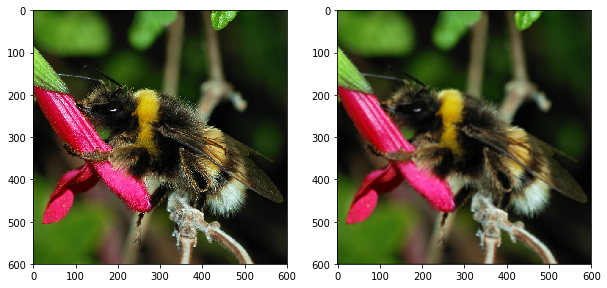

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv.predict(img_in)[0].astype('uint8'));

#### Questions

- Define a Conv2D layer with 3 filters (5x5) that compute the identity function (preserve the input image without mixing the colors).
- Change the stride to 2. What is the size of the output image?
- Change the padding to 'VALID'. What do you observe?

Shape of result with SAME padding: (1, 300, 300, 3)
Shape of result with VALID padding: (1, 298, 298, 3)


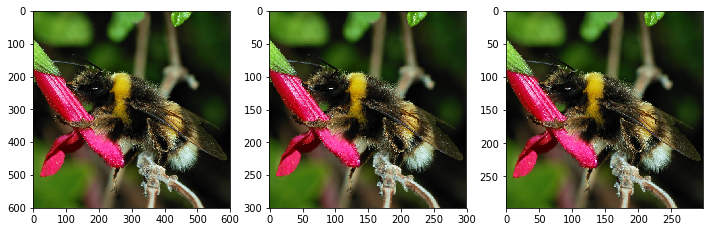

In [17]:
def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape)
    array[2, 2] = np.eye(3)
    return array


conv_strides_same = Sequential([
    Conv2D(filters=3, kernel_size=5, strides=2,
           padding="same", kernel_initializer=my_init,
           input_shape=(None, None, 3))
])
conv_strides_valid = Sequential([
    Conv2D(filters=3, kernel_size=5, strides=2,
           padding="valid", kernel_initializer=my_init,
           input_shape=(None, None, 3))
])

img_in = np.expand_dims(sample_image, 0)
img_out_same = conv_strides_same.predict(img_in)
img_out_valid = conv_strides_valid.predict(img_in)

print("Shape of result with SAME padding:", img_out_same.shape)
print("Shape of result with VALID padding:", img_out_valid.shape)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
ax0.imshow(img_in[0].astype(np.uint8))
ax1.imshow(img_out_same[0].astype(np.uint8))
ax2.imshow(img_out_valid[0].astype(np.uint8))

# We observe that the stride divided the size of the image by 2
# In the case of 'VALID' padding mode, no padding is added, so 
# the size of the ouput image is actually 1 less because of the
# kernel size

### 3. Working on edge detection on Grayscale image

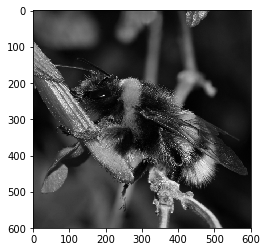

In [18]:
# convert image to greyscale
grey_sample_image = sample_image.sum(axis=2) / 3.

# add the channel dimension even if it's only one channel so
# as to be consistent with Keras expectations.
grey_sample_image = grey_sample_image[:, :, np.newaxis]


# matplotlib does not like the extra dim for the color channel
# when plotting gray-level images. Let's use squeeze:
plt.imshow(np.squeeze(grey_sample_image.astype(np.uint8)),
           cmap=plt.cm.gray);

#### Questions 

- Build an edge detector using `Conv2D` on greyscale image
- You may experiment with several kernels to find a way to detect edges
- https://en.wikipedia.org/wiki/Kernel_(image_processing)

Try `Conv2D?` or press `shift-tab` to get the documentation. You may get help at https://keras.io/layers/convolutional/

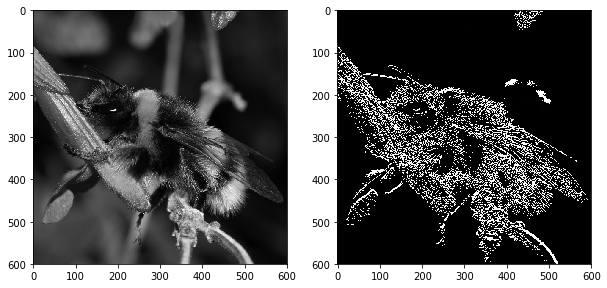

In [19]:
def my_init(shape, dtype=None):
    array = np.array([
        [0.0,  0.2, 0.0],
        [0.0, -0.2, 0.0],
        [0.0,  0.0, 0.0],
    ])
    # adds two axis to match the required shape (3,3,1,1)
    return np.expand_dims(np.expand_dims(array,-1),-1)


conv_edge = Sequential([
    Conv2D(kernel_size=(3,3), filters=1,
           padding="same", kernel_initializer=my_init,
           input_shape=(None, None, 1))   
])


img_in = np.expand_dims(grey_sample_image, 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(img_in[0]).astype(np.uint8),
           cmap=plt.cm.gray);
ax1.imshow(np.squeeze(img_out[0]).astype(np.uint8),
           cmap=plt.cm.gray);

# We only showcase a vertical edge detection here.
# Many other kernels work, for example differences
# of centered gaussians (sometimes called mexican-hat
# connectivity)
#
# You may try with this filter as well
# np.array([
#         [ 0.1,  0.2,  0.1],
#         [ 0.0,  0.0,  0.0],
#         [-0.1, -0.2, -0.1],
#     ])

### 4. Pooling and strides with convolutions

#### Questions

- Use `MaxPool2D` to apply a 2x2 max pool with strides 2 to the image. What is the impact on the shape of the image?
- Use `AvgPool2D` to apply an average pooling.
- Is it possible to compute a max pooling and an average pooling with well chosen kernels?

**Bonus**
- Implement a 3x3 average pooling with a regular convolution `Conv2D`, with well chosen strides, kernel and padding

In [20]:
from keras.layers import MaxPool2D, AvgPool2D

input shape: (1, 600, 600, 3)
output shape: (1, 300, 300, 3)


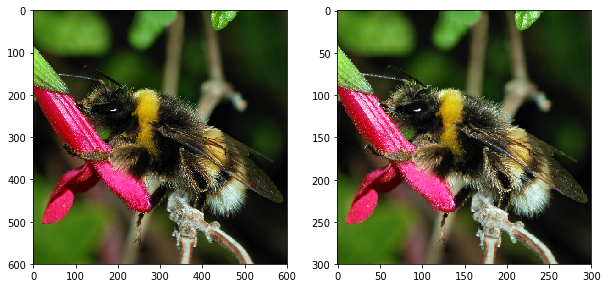

In [21]:
max_pool = Sequential([MaxPool2D(2, strides=2, input_shape=(None, None, 3))])
img_in = np.expand_dims(sample_image, 0)
img_out = max_pool.predict(img_in)

print("input shape:", img_in.shape)
print("output shape:", img_out.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

# it is not possible to build a max pooling with a regular convolution
# however it is possible to build average pooling with well  
# chosen strides and kernel


input shape: (1, 600, 600, 3)
output avg pool shape: (1, 200, 200, 3)
output conv shape: (1, 200, 200, 3)


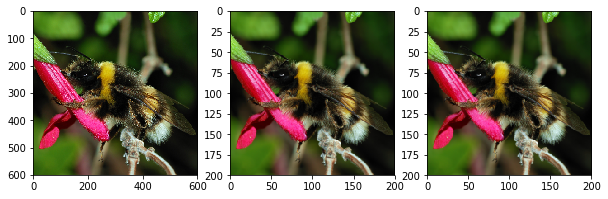

In [22]:
avg_pool = Sequential([AvgPool2D(3, strides=3, input_shape=(None, None, 3))])

img_in = np.expand_dims(sample_image, 0)
img_out_avg_pool = avg_pool.predict(img_in)

# Same operation implemented with a convolution

def my_init(shape=(3, 3, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=dtype)
    array[:, :, 0, 0] = 1 / 9.
    array[:, :, 1, 1] = 1 / 9.
    array[:, :, 2, 2] = 1 / 9.
    return array


conv_avg = Sequential([
    Conv2D(kernel_size=3, filters=3, strides=3,
           padding="same", kernel_initializer=my_init,
           input_shape=(None, None, 3))
])
img_out_conv = conv_avg.predict(np.expand_dims(sample_image, 0))

print("input shape:", img_in.shape)
print("output avg pool shape:", img_out_avg_pool.shape)
print("output conv shape:", img_out_conv.shape)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out_avg_pool[0].astype('uint8'))
ax2.imshow(img_out_conv[0].astype('uint8'));

# Note that the numerical computation/approximation might
# be slightly different in the two cases